In [5]:
import librosa
import numpy as np
import pandas as pd
import os
import scipy.signal
import matplotlib.pyplot as plt
from librosa.feature import mfcc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# **STFT**

## - creating function compute_rfft for rfft

rfft — це реальне швидке перетворення Фур'є
(Real Fast Fourier Transform), спеціальна версія FFT, яка працює тільки з реальними сигналами і повертає тільки позитивні частоти.

#### Формула для rFFT (реального швидкого перетворення Фур'є)

Оскільки $x_n$​ є реальним сигналом, його спектр симетричний:
$$X_{N−k}=X_k∗$$


де $X_k^∗$​ — це комплексне спряжене $X_k$​.

Отже, нам достатньо обчислювати лише першу половину спектру, тобто:
$$Xk=\sum_{n=0}^{N−1}x_ne^{−j2\pi kn/N},k=0,1,...,N/2$$

Тут:

- $k$ змінюється тільки від $0$ до $N/2$.

- Це означає, що rFFT повертає $(N/2 + 1)$ значень (бо враховується і частота Nyquist $f_s/2$).

## - creating function compute_sfft for sfft

SFFT — це локалізоване у часі перетворення Фур'є, яке використовується для аналізу незмінних у часі сигналів.

#### Формула для SFFT (Short-Time Fourier Transform)

$X(t,f)=n=\sum_{n=−\infty}^\infty​x(n)w(n−t)e^{−j2 \pi fn}$
де:

- $x(n)$ — дискретний вхідний сигнал.

- $w(n−t)$ — віконна функція (наприклад, Hann або Hamming).

- $e^{−j2 \pi fn}$ — комплексний експоненційний множник (база Фур'є).

- $X(t,f)$ — спектр сигналу у часово-частотному просторі.

У матричному вигляді:

- Результат SFFT — це матриця $X(T,F)$, де:

    - $T$ — кількість часових вікон.

    - $F$ — кількість частотних компонент.

In [12]:
def compute_rfft(signal, fs):
    N = len(signal)
    spectrum = np.zeros(N // 2 + 1, dtype=complex)
    for k in range(N // 2 + 1):
        for n in range(N):
            spectrum[k] += signal[n] * np.exp(-2j * np.pi * k * n / N)
    
    freqs = np.fft.rfftfreq(N, d=1/fs)
    return freqs, spectrum

# def compute_sfft(signal, fs, window='hann', nperseg=512, noverlap=256, plot=True):
#     step = nperseg - noverlap
#     num_windows = (len(signal) - noverlap) // step
    
#     if window == 'hann':
#         win = np.hanning(nperseg)
#     else:
#         win = np.ones(nperseg)
    
#     f = np.fft.rfftfreq(nperseg, d=1/fs)
#     t = np.arange(num_windows) * step / fs
    
#     Zxx = np.zeros((len(f), len(t)), dtype=complex)
#     for i in range(num_windows):
#         segment = signal[i * step : i * step + nperseg] * win
#         Zxx[:, i] = compute_rfft(segment, fs)[1]
    
#     freqs, spectrum = compute_rfft(signal, fs)
    
#     if plot:
#         plt.figure(figsize=(10, 6))
#         plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
#         plt.colorbar(label='Амплітуда')
#         plt.ylabel('Частота (Гц)')
#         plt.xlabel('Час (с)')
#         plt.title('Спектрограма сигналу (SFFT)')
#         plt.show()
        
#         plt.figure(figsize=(8, 5))
#         plt.plot(freqs, np.abs(spectrum))
#         plt.xlabel('Частота (Гц)')
#         plt.ylabel('Амплітуда')
#         plt.title('Амплітудний спектр (rFFT)')
#         plt.grid()
#         plt.show()
    
#     return f, t, Zxx, freqs, spectrum
# def compute_sfft(signal, fs, nperseg=512, noverlap=256, plot=True):
#     f, t, Zxx = stft(signal, fs, nperseg=nperseg, noverlap=noverlap)
    
#     if plot:
#         plt.figure(figsize=(10, 6))
#         plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
#         plt.colorbar(label='Амплітуда')
#         plt.ylabel('Частота (Гц)')
#         plt.xlabel('Час (с)')
#         plt.title('Спектрограма сигналу (STFT)')
#         plt.show()
    
#     return f, t, Zxx

    
def compute_sfft(signal, fs, nperseg=512, noverlap=256, plot=True):
    """
    Обчислення спектрограми за допомогою STFT.
    
    signal: аудіосигнал
    fs: частота дискретизації
    nperseg: довжина кожного сегмента
    noverlap: кількість перехрестя
    plot: якщо True, то будується графік спектрограми
    """
    Zxx = librosa.stft(signal, n_fft=nperseg, hop_length=noverlap)
    f, t = librosa.core.fft_frequencies(sr=fs), librosa.core.times_like(Zxx)

    # Амплітуда спектра (модуль комплексних чисел)
    Zxx_abs = np.abs(Zxx)

    if plot:
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(t, f, Zxx_abs, shading='gouraud')
        plt.colorbar(label='Амплітуда')
        plt.ylabel('Частота (Гц)')
        plt.xlabel('Час (с)')
        plt.title('Спектрограма сигналу (STFT)')
        plt.show()
    
    return f, t, Zxx_abs  #

# Computing PCA

PCA (Principal Component Analysis) — це метод зменшення вимірності даних, який дозволяє перетворити набір змінних (фіч) у новий набір змінних, який називається головними компонентами (principal components). Це робиться таким чином, щоб нові змінні були лінійно незалежними і містили найбільшу кількість варіативності (інформації) з початкових змінних. Процес може бути розділений на кілька етапів.

**Формули**:

- Центрування даних:

    $X_{центр}=X−\mu$

де $\mu$ — середнє значення по кожній ознаці.

- Ковариаційна матриця:

    $C=\frac{1}{n−1}X_{центр}^TX_{центр}$

    Власні значення та власні вектори:

    $Cv=λv$

для кожного $i$, де $v_i$​ — власний вектор, $λ_i$​ — відповідне власне значення.

- Перетворення даних:

    $X′=XV_k$​

де $V_k$​ — матриця з вибраними власними векторами (головними компонентами).

**Вибір кількості головних компонент**:

Якщо ви хочете зберегти певну частку варіативності даних, можна вибрати кількість компонент, яка покриває, наприклад, $95%$ загальної дисперсії. Це робиться на основі сумарних власних значень:

$$\frac{\sum_{i=1}^k λ_i}{\sum_{i=1}^m λ_i}$$


де $λ_i$​ — власні значення, а $k$ — кількість вибраних компонент.

**Як це працює на практиці**:

1. Центруєте дані (віднімаєте середнє для кожної змінної).

2. Обчислюєте ковариаційну матрицю, щоб зрозуміти, як змінні пов'язані одна з одною.

3. Знаходите напрямки (головні компоненти), по яких дані найбільше розподіляються.

4. Вибираєте кілька головних компонент, які зберігають більшість варіативності.

5. Проектуєте дані в нову систему координат.

In [9]:
def pca(X, num_components):
    """
    Реалізація PCA без використання сторонніх бібліотек.

    Параметри:
    - X: np.array - матриця даних, розміри (n_samples, n_features)
    - num_components: int - кількість головних компонент, які ми хочемо зберегти.

    Повертає:
    - X_pca: np.array - перетворені дані в новому просторі головних компонент.
    - components: np.array - головні компоненти (власні вектори).
    - explained_variance: np.array - пояснена дисперсія (власні значення).
    """
    # 1. Центрування даних (віднімання середнього значення по кожній ознаці)
    mean = np.mean(X, axis=0)  # Середнє значення по кожній ознаці
    X_centered = X - mean  # Центровані дані

    # 2. Обчислення ковариаційної матриці
    covariance_matrix = np.cov(X_centered, rowvar=False)  # ковариація по ознаках

    # 3. Обчислення власних значень та власних векторів
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # 4. Сортування власних значень та відповідних власних векторів за спаданням
    sorted_indices = np.argsort(eigenvalues)[::-1]  # індекси від найбільшого до найменшого
    eigenvalues_sorted = eigenvalues[sorted_indices]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]

    # 5. Вибір перших num_components компонент (головних компонент)
    components = eigenvectors_sorted[:, :num_components]  # Вибір перших компонент
    explained_variance = eigenvalues_sorted[:num_components]  # Пояснена дисперсія для вибраних компонент

    # 6. Проекція даних на нові головні компоненти
    X_pca = X_centered.dot(components)  # Проекція на головні компоненти

    return X_pca, components, explained_variance


## Щоб перейти до Gaussian Discriminant Analysis (GDA) після зменшення розмірності з PCA, потрібно виконати наступні кроки:

1. Підготовка даних для GDA: Після застосування PCA, ви отримуєте нові зменшені вектори ознак (матриця X_pca). Тепер вам потрібно підготувати ці дані для застосування GDA. Ви повинні мати емоції, до яких належать ваші зразки даних, оскільки GDA — це метод для класифікації.

2. Навчання GDA: У GDA передбачається, що кожний клас (емоція) має нормальний розподіл з окремими параметрами (середнє та ковариаційна матриця) для кожного класу. Вам потрібно буде навчити модель GDA, оцінюючи ці параметри для кожного класу на основі зменшеного набору ознак.

3. Прогнозування GDA: Після навчання ви зможете використовувати GDA для прогнозування емоції для нових, невідомих даних.

# Кроки реалізації GDA після PCA

- Навчання моделі GDA: Для кожного класу (емоції) GDA оцінює середнє значення та ковариаційну матрицю для зменшених ознак.

**Формули GDA**:

- Для кожного класу $y_k$​, середнє $\mu_k$​ і ковариаційна матриця $Σk$​ обчислюються як:
    
$$\mu_k=\frac{1}{N_k} \sum_{i\in C_k}X_i$$

де $N_k$​ — кількість зразків у класі $y_k$​, а $C_k$​ — зразки, що належать класу $y_k$​.

$$\sum_k=\frac{1}{N_k-1} \sum_{i \in C_k}(X_i−\mu_k)(X_i−\mu_k)^T$$


де $X_i$​ — вектор ознак зменшеної розмірності після PCA.

Для класифікації нових зразків, використовується правило Байєса. Потрібно обчислити ймовірність для кожного класу, і передбачити клас, який має максимальну ймовірність.

**Логарифм ймовірності класу для зразка $X$:**

$$logP(y_k​∣X)=−\frac{1}{2}​(X−μ_k​)^T \sum^{-1}(X−μ_k​)−\frac{1}{2}​log∣\sum∣+logP(y_k​)$$

In [10]:
import numpy as np

# Функція для навчання GDA
def gda_train(X, y):
    """
    Навчання GDA для класифікації.
    X - матриця зменшених ознак (samples x features)
    y - вектор міток класів (sample_labels)
    
    Повертає:
    - mu: середнє для кожного класу (C x features)
    - sigma: спільна ковариаційна матриця
    - priors: ймовірності класів
    """
    classes = np.unique(y)  # Унікальні класи
    mu = np.zeros((len(classes), X.shape[1]))  # Матрична форма для середніх
    sigma = np.zeros((X.shape[1], X.shape[1]))  # Ковариаційна матриця
    
    priors = np.zeros(len(classes))  # Ймовірності класів

    # Оцінка середнього та ковариаційної матриці для кожного класу
    for i, c in enumerate(classes):
        X_c = X[y == c]  # Вибір зразків для класу c
        mu[i] = np.mean(X_c, axis=0)  # Оцінка середнього для класу c
        sigma += np.cov(X_c.T) * len(X_c)  # Оцінка ковариаційної матриці (сумування по класах)
        priors[i] = len(X_c) / len(X)  # Оцінка апріорної ймовірності

    sigma /= len(X)  # Середнє по всіх класах

    return mu, sigma, priors


# Функція для класифікації GDA
def gda_predict(X, mu, sigma, priors):
    """
    Класифікація нових зразків за допомогою GDA.
    X - матриця зменшених ознак (samples x features)
    mu - середнє для кожного класу
    sigma - спільна ковариаційна матриця
    priors - ймовірності класів
    
    Повертає:
    - y_pred: передбачені мітки класів
    """
    num_samples = X.shape[0]
    num_classes = mu.shape[0]
    y_pred = np.zeros(num_samples)

    # Обчислення логарифмів ймовірностей для кожного класу
    for i in range(num_samples):
        log_likelihoods = np.zeros(num_classes)
        for j in range(num_classes):
            diff = X[i] - mu[j]
            log_likelihood = -0.5 * np.dot(np.dot(diff, np.linalg.inv(sigma)), diff.T) \
                            - 0.5 * np.log(np.linalg.det(sigma)) \
                            + np.log(priors[j])
            log_likelihoods[j] = log_likelihood

        y_pred[i] = np.argmax(log_likelihoods)  # Вибір класу з найвищою ймовірністю

    return y_pred


In [24]:
import os
import numpy as np
import librosa

def read_audio_files(directory, fixed_length=1):
    EMOTIONS = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }
    
    audio_data = []
    print(f"Scanning directory: {directory}")

    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith(".wav"):
                parts = filename.split('-')
                if len(parts) >= 3:
                    emotion_code = parts[2]
                    emotion = EMOTIONS.get(emotion_code, "unknown")
                    
                    file_path = os.path.join(root, filename)
                    audio, sr = librosa.load(file_path, sr=None)
                    
                    f, t, Zxx = compute_sfft(audio, sr, plot=False)
                    
                    # Standardize feature size
                    if Zxx.shape[1] > fixed_length:
                        Zxx = Zxx[:, :fixed_length]  # Truncate
                    elif Zxx.shape[1] < fixed_length:
                        pad_width = fixed_length - Zxx.shape[1]
                        Zxx = np.pad(Zxx, ((0, 0), (0, pad_width)), mode='constant')  # Zero-pad
                    
                    audio_data.append((Zxx.T, emotion))  # Transpose for PCA processing later
    
    return audio_data

def main(data_directory, num_components=57):
    data = read_audio_files(data_directory)
    print("data shape:", len(data))
    
    # Extract features and labels
    raw_features = np.array([item[0] for item in data])
    print("raw shape: ", raw_features.shape)
    y = np.array([[item[1]]*1 for item in data]).flatten()
    print(f"y shape: {y.shape}")
    unique_labels = list(set(y))  # Унікальні назви емоцій
    label_mapping = {label: i for i, label in enumerate(unique_labels)}  # Відображення у числа
    y = np.array([label_mapping[label] for label in y])  # Перетворення

    # y = np.array([item[1]] * fixed_length for item in data).flatten()

    
    # Apply PCA
    X_pca, components, explained_variance = pca(np.vstack(raw_features), num_components)
    
    # Standardize feature size after PCA
    min_len = min(x.size for x in X_pca)
    X = np.array([np.abs(x.flatten()[:min_len]) for x in X_pca])
    
    print("X shape:", X.shape)
    print("First sample shape:", X[0].shape if len(X) > 0 else "Empty")
    
    # Train GDA
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    
    mu, sigma, priors = gda_train(X, y)
    
    # Regularization
    epsilon = 1e-6
    sigma += np.eye(sigma.shape[0]) * epsilon
    
    # Predict using GDA
    y_pred = gda_predict(X, mu, sigma, priors)
    
    # Compute accuracy
    accuracy = np.mean(y_pred == y)
    print(f"Model Accuracy: {accuracy * 100:.2f}%")
    
if __name__ == "__main__":
    for i in range(1, 58):
        main("./Audio_Speech_Actors_01-24", i)

Scanning directory: ./Audio_Speech_Actors_01-24
data shape: 1440
raw shape:  (1440, 1, 257)
y shape: (1440,)
X shape: (1440, 1)
First sample shape: (1,)
X shape: (1440, 1), y shape: (1440,)
Model Accuracy: 14.24%
Scanning directory: ./Audio_Speech_Actors_01-24
data shape: 1440
raw shape:  (1440, 1, 257)
y shape: (1440,)
X shape: (1440, 2)
First sample shape: (2,)
X shape: (1440, 2), y shape: (1440,)
Model Accuracy: 15.14%
Scanning directory: ./Audio_Speech_Actors_01-24
data shape: 1440
raw shape:  (1440, 1, 257)
y shape: (1440,)
X shape: (1440, 3)
First sample shape: (3,)
X shape: (1440, 3), y shape: (1440,)
Model Accuracy: 16.11%
Scanning directory: ./Audio_Speech_Actors_01-24
data shape: 1440
raw shape:  (1440, 1, 257)
y shape: (1440,)
X shape: (1440, 4)
First sample shape: (4,)
X shape: (1440, 4), y shape: (1440,)
Model Accuracy: 16.39%
Scanning directory: ./Audio_Speech_Actors_01-24
data shape: 1440
raw shape:  (1440, 1, 257)
y shape: (1440,)
X shape: (1440, 5)
First sample shape: 

In [ ]:
def read_files(dir_path: str):
    
    # List of all emotions
    EMOTIONS = {'01' : 'neutral',
                '02' : 'calm',
                '03' : 'happy',
                '04' : 'sad',
                '05' : 'angry',
                '06' : 'fearful',
                '07' : 'disgust',
                '08' : 'surprised'}
    
    # Data that will be returned
    audio_data = []
    
    #reading files from dirs
    for root, _, files in os.walk(dir_path):  # Recursively traverse directories
        for filename in files:
            if filename.endswith(".wav"):
                parts = filename.split('-')
                if len(parts) >= 3:  # Ensure filename format is correct
                    
                    # Getting emotion code
                    emotion_code = parts[2]
                    emotion = EMOTIONS.get(emotion_code, "unknown")
                    
                    # Loading audio with original sampling rate
                    file_path = os.path.join(root, filename)
                    audio, sampling_rate = librosa.load(file_path, sr=None)
                    
                    freqs, spectrum = compute_rfft(audio, sr)
                    f, t, Zxx, _, _ = compute_sfft(audio, sr, plot=False)
                    
                    audio_data.append((audio, emotion, freqs, spectrum, f, t, Zxx))))
    
    return audio_data, sampling_rate


data, sampling_rate = read_files("./Audio_Speech_Actors_01-24")

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def main(data_directory):
    data = read_audio_files(data_directory)
    min_len = min([item[0].size for item in data])
    X = np.array([np.abs(item[0].flatten()[:min_len]) for item in data])  # Беремо лише частину ознак
    y = np.array([item[1] for item in data])  # Мітки класів

    # Перевірка форми даних
    print("X shape:", X.shape)
    print("First sample shape:", X[0].shape if len(X) > 0 else "Empty")

    # Розділення на навчальні та тестові дані
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Стандартизація даних
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Створення і навчання моделі SVM
    svm_model = SVC(kernel='rbf', gamma='scale')  # Використовуємо ядро RBF, яке зазвичай добре працює для таких задач
    svm_model.fit(X_train_scaled, y_train)

    # Прогнозування на тестових даних
    y_pred = svm_model.predict(X_test_scaled)

    # Обчислення точності моделі
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM Model Accuracy: {accuracy * 100:.2f}%")

if __name__ == "__main__":
    main("./Audio_Speech_Actors_01-24")

Scanning directory: ./Audio_Speech_Actors_01-24
X shape: (1440, 257)
First sample shape: (257,)
SVM Model Accuracy: 9.72%


In [91]:
def read_audio_files(directory, fixed_length=1):
    EMOTIONS = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }
    
    audio_data = []
    print(f"Scanning directory: {directory}")

    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith(".wav"):
                parts = filename.split('-')
                if len(parts) >= 3:
                    emotion_code = parts[2]
                    emotion = EMOTIONS.get(emotion_code, "unknown")
                    
                    file_path = os.path.join(root, filename)
                    audio, sr = librosa.load(file_path, sr=None)
                    row = {
                        'emotion': emotion.lower(),
                        'sample': audio,
                        'sample_rate': sr,
                    }
                    
                    audio_data.append(row)  # Transpose for PCA processing later
    
    return pd.DataFrame(audio_data)

df = read_audio_files("./Audio_Speech_Actors_01-24")
df.head()

print(df["emotion"].unique())
print(df["sample_rate"].unique())


Scanning directory: ./Audio_Speech_Actors_01-24
['angry' 'calm' 'sad' 'happy' 'neutral' 'surprised' 'fearful' 'disgust']
[48000]


In [92]:
def compute_stft(signal, sample_rate, n_fft=256, hop_length=None, window="hann"):
    hop_length = hop_length or n_fft // 2
    f, t, Zxx = scipy.signal.stft(signal, fs=sample_rate, nperseg=n_fft, noverlap=hop_length, window=window)
    
    return np.abs(Zxx), f, t

def apply_stft(row):
    stft_magnitude, frequencies, time_bins = compute_stft(row["sample"], row["sample_rate"])
    return pd.Series([stft_magnitude, frequencies, time_bins])

df[["fft_magnitude", "frequencies", "time_bins"]]  = df.apply(apply_stft, axis=1)

In [93]:
df.head()

,emotion,sample,sample_rate,fft_magnitude,frequencies,time_bins
0,angry,"[3.0517578e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,"[[1.9086574e-06, 1.0182923e-05, 7.911935e-06, ...","[0.0, 187.5, 375.0, 562.5, 750.0, 937.5, 1125....","[0.0, 0.0026666666666666666, 0.005333333333333..."
1,calm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,"[[0.0, 8.6955865e-08, 1.7568774e-06, 6.351541e...","[0.0, 187.5, 375.0, 562.5, 750.0, 937.5, 1125....","[0.0, 0.0026666666666666666, 0.005333333333333..."
2,sad,"[-3.0517578e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",48000,"[[2.3841858e-07, 5.522569e-07, 2.3810067e-06, ...","[0.0, 187.5, 375.0, 562.5, 750.0, 937.5, 1125....","[0.0, 0.0026666666666666666, 0.005333333333333..."
3,calm,"[3.0517578e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,"[[2.3841858e-07, 1.3285064e-06, 5.112653e-06, ...","[0.0, 187.5, 375.0, 562.5, 750.0, 937.5, 1125....","[0.0, 0.0026666666666666666, 0.005333333333333..."
4,happy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,"[[0.0, 2.1135932e-07, 2.5662527e-07, 2.4727115...","[0.0, 187.5, 375.0, 562.5, 750.0, 937.5, 1125....","[0.0, 0.0026666666666666666, 0.005333333333333..."


[[7.22835068e-07 2.51669599e-06 2.75948810e-06 ... 2.41207943e-07
  9.80303071e-07 1.40388272e-06]
 [4.49885329e-06 3.07030041e-06 4.05794162e-06 ... 2.18797894e-07
  7.46204137e-07 1.33726076e-06]
 [7.31175260e-06 3.81102632e-06 6.54859468e-06 ... 1.57459681e-07
  1.79567337e-07 1.20192055e-06]
 ...
 [7.21132778e-07 6.44036788e-07 7.59323825e-07 ... 1.09237035e-07
  4.44570219e-07 1.41442200e-07]
 [4.26779422e-07 6.26759629e-07 7.00493274e-07 ... 1.42376862e-07
  4.79935920e-07 9.20601053e-08]
 [1.97620025e-07 7.41156043e-07 3.49583331e-07 ... 1.55042102e-07
  4.79074174e-07 2.23699814e-09]]


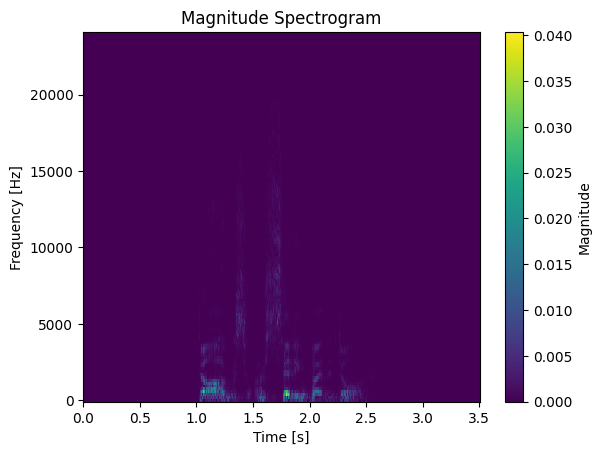

In [94]:
fft_magnitude = df.loc[5, "fft_magnitude"]
frequencies = df.loc[5, "frequencies"]
time_bins = df.loc[5, "time_bins"]
print(np.array(fft_magnitude))
plt.pcolormesh(time_bins, frequencies, fft_magnitude)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Magnitude Spectrogram')
plt.colorbar(label='Magnitude')
plt.show()

In [95]:
def shape(array):
    return array.shape
df["shape"] = df["fft_magnitude"].apply(shape)
lst = df["shape"].unique()
print(sorted(lst)[::-1])

[(129, 1978), (129, 1916), (129, 1878), (129, 1853), (129, 1841), (129, 1828), (129, 1816), (129, 1803), (129, 1791), (129, 1778), (129, 1753), (129, 1741), (129, 1728), (129, 1716), (129, 1703), (129, 1691), (129, 1678), (129, 1666), (129, 1653), (129, 1641), (129, 1628), (129, 1616), (129, 1603), (129, 1591), (129, 1578), (129, 1566), (129, 1553), (129, 1541), (129, 1528), (129, 1516), (129, 1503), (129, 1490), (129, 1478), (129, 1465), (129, 1453), (129, 1440), (129, 1428), (129, 1415), (129, 1403), (129, 1390), (129, 1378), (129, 1365), (129, 1353), (129, 1340), (129, 1328), (129, 1315), (129, 1303), (129, 1290), (129, 1278), (129, 1265), (129, 1253), (129, 1240), (129, 1228), (129, 1215), (129, 1203), (129, 1190), (129, 1178), (129, 1165), (129, 1153), (129, 1140), (129, 1128), (129, 1115), (129, 1103)]


In [96]:
all_values = np.concatenate(df['frequencies'].values)
unique_values = np.unique(all_values)
print(len(unique_values))

129


In [97]:
def row_mfcc(row):
    mfcc_features = mfcc(y=row["sample"], sr=row["sample_rate"], n_mfcc=100)
    mean_mfcc = np.mean(mfcc_features, axis=1)
    var_mfcc = np.var(mfcc_features, axis=1)
    return np.concatenate((mean_mfcc, var_mfcc)) 

df["mfcc"] = df.apply(row_mfcc, axis=1)

In [98]:
length = [len(lst) for lst in df["mfcc"]]
print(length)

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,

In [117]:
table = np.array(df['mfcc'].tolist())
pca = PCA(140)
pcaed_table = pca.fit_transform(table)

In [118]:
print(pca.explained_variance_ratio_)

[9.14457142e-01 7.66586661e-02 3.66779114e-03 1.18983770e-03
 9.00081126e-04 5.73845231e-04 3.80527956e-04 3.20921041e-04
 2.90190830e-04 1.86166799e-04 1.84430755e-04 1.31509689e-04
 1.16638752e-04 1.07420601e-04 9.04953849e-05 7.15300994e-05
 6.67250206e-05 5.92078140e-05 5.48767348e-05 5.00378737e-05
 4.03430859e-05 3.50494774e-05 3.21619518e-05 2.85294609e-05
 2.62136873e-05 2.37500008e-05 2.22758972e-05 2.15344699e-05
 1.96643377e-05 1.81349042e-05 1.76082940e-05 1.64991543e-05
 1.38682590e-05 1.31099923e-05 1.00887546e-05 9.32283456e-06
 8.63539299e-06 8.05354375e-06 7.14815860e-06 6.88129239e-06
 6.17756405e-06 5.85309499e-06 4.99789803e-06 4.57443502e-06
 3.73877015e-06 3.41437044e-06 3.08268955e-06 2.86516047e-06
 2.51734377e-06 2.29821626e-06 2.06981417e-06 1.87074181e-06
 1.55794794e-06 1.36218569e-06 1.19200922e-06 1.09349014e-06
 1.05187212e-06 8.81188441e-07 8.11832138e-07 6.86595968e-07
 6.64875245e-07 5.93263621e-07 5.40212113e-07 4.74767205e-07
 4.23470453e-07 4.004224

In [119]:
scaled_table = pcaed_table
scaler = StandardScaler()
final_table = scaler.fit_transform(scaled_table)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(final_table,np.array(df['emotion'].tolist()), test_size=0.2, train_size=0.8)

In [121]:
clf = SVC(kernel='linear')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.5381944444444444


In [116]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.5520833333333334


In [88]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
EMOTIONS = {0 : 'neutral',
            1 : 'calm',
            2 : 'happy',
            3 : 'sad',
            4 : 'angry',
            5 : 'fearful',
            6 : 'disgust',
            7 : 'surprised',
            'neutral' : 0,
            'calm' : 1,
            'happy' : 2,
            'sad' : 3,
            'angry' : 4,
            'fearful' : 5,
            'disgust' : 6,
            'surprised' : 7}
model.fit(X_train, [EMOTIONS[y] for y in y_train])

y_pred = model.predict(X_test)
y_pred = [EMOTIONS[y] for y in y_pred]

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))

XGBoost Accuracy: 0.5625


In [108]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Logistic Regression with PCA Accuracy:", accuracy_score(y_test, y_pred))


Logistic Regression with PCA Accuracy: 0.5451388888888888


In [110]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

class GDA:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = {}  # P(y)
        self.means = {}   # mu_c
        self.cov = np.cov(X.T)  # Спільна коваріаційна матриця (shared covariance)
        
        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = len(X_c) / len(X)  # P(y = c)
            self.means[c] = np.mean(X_c, axis=0)  # mu_c
        
    def predict(self, X):
        predictions = []
        for x in X:
            scores = {}
            for c in self.classes:
                # Обчислення дискримінантної функції
                likelihood = multivariate_normal.pdf(x, mean=self.means[c], cov=self.cov)
                scores[c] = self.priors[c] * likelihood  # P(y) * P(x | y)
            
            predictions.append(max(scores, key=scores.get))  # Обираємо клас з найвищою ймовірністю
        return np.array(predictions)

# Навчання GDA на датасеті
gda = GDA()
gda.fit(X_train, y_train)
y_pred = gda.predict(X_test)

# Оцінка точності
accuracy = accuracy_score(y_test, y_pred)
print("GDA Accuracy:", accuracy)


GDA Accuracy: 0.5833333333333334
